In [51]:
from pathlib import Path
from typing import Optional, Callable, Dict, List
import numpy as np
import torch
from torch.utils.data import Dataset
from projectaria_tools.core.sensor_data import ImageData
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sophus import SE3, SO3
from projectaria_tools.core import data_provider
from nymeria.data_provider import NymeriaDataProvider
from nymeria.recording_data_provider import RecordingDataProvider, AriaStream
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize, Compose
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [52]:
class NymeriaPoseDataset(Dataset):

    def __init__(
        self,
        seq_root: Path,
        transform: Optional[Callable] = None,
        half: bool = True,
    ):
        super().__init__()
        self.seq_root = Path(seq_root)
        self.transform = transform
        self.half = half
        self.dp = NymeriaDataProvider(
            sequence_rootdir=self.seq_root, load_wrist=False, load_observer=False
        )
        self.rec_head: RecordingDataProvider = self.dp.recording_head
        assert self.rec_head and self.rec_head.has_rgb, "no RGB stream found"
        self.rgb_sid = StreamId(AriaStream.camera_rgb.value)
        self.vrs_dp = self.rec_head.vrs_dp
        self._num_frames = self.vrs_dp.get_num_data(self.rgb_sid)

        self.cam_calib = (
            self.vrs_dp.get_device_calibration().get_camera_calib("camera-rgb")
        )
        w, h = self.cam_calib.get_image_size()
        if half:
            w, h = w // 2, h // 2
        self.img_size = (h, w)

    def __len__(self) -> int:
        return self._num_frames

    @staticmethod
    def _unique_joints(bones: np.ndarray) -> np.ndarray:
        """XSens bones → 23 distinct joint positions."""
        pts = np.zeros((23, 3), np.float32)
        for b, (child, parent) in enumerate(bones):
            pts[b + 1] = child
            if b == 0:
                pts[0] = parent
        return pts
    def __getitem__(self, idx: int):
        img_data, meta = self.vrs_dp.get_image_data_by_index(self.rgb_sid, idx)
        if hasattr(meta, "time_code_timestamp_ns"):
            t_code_ns = meta.time_code_timestamp_ns
        elif hasattr(self.vrs_dp, "convert_device_time_to_timecode_time_ns"):
            t_code_ns = self.vrs_dp.convert_device_time_to_timecode_time_ns(
                meta.capture_timestamp_ns
            )
        else:
            t_code_ns = meta.capture_timestamp_ns
        poses = self.dp.get_synced_poses(t_code_ns)
        bones = poses["xsens"]
        joints_w = self._unique_joints(bones)
        T_W_D: SE3 = poses["recording_head"].transform_world_device
        T_D_C: SE3 = self.cam_calib.get_transform_device_camera()
        R_WD = T_W_D.rotation().to_matrix()
        t_WD = T_W_D.translation().ravel()
        R_DC = T_D_C.rotation().to_matrix()
        t_DC = T_D_C.translation().ravel()
        R_WC = R_WD @ R_DC
        t_WC = (R_WD @ t_DC).ravel() + t_WD
        joints_c = (R_WC.T @ (joints_w - t_WC).T).T  
        uv = []
        for p in joints_c:
            pix = self.cam_calib.project(p)
            if pix is None:
                uv.append([-1.0, -1.0])
            else:
                u, v = pix
                if self.half:
                    u, v = u / 2.0, v / 2.0
                uv.append([u, v])
        joints_2d = torch.tensor(uv, dtype=torch.float32)
        arr = img_data.to_numpy_array()
        if self.half:
            arr = arr[::2, ::2]
        frame = torch.from_numpy(arr).permute(2, 0, 1).float() / 255.0
        if self.transform:
            frame = self.transform(frame)

        return frame, torch.from_numpy(joints_c).float(), joints_2d

In [ ]:
root    = Path(r"C:\Users\Damir\nymeria_dataset\d\20230622_s0_john_solomon_act2_8urygm")
norm = Compose([Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])
ds      = NymeriaPoseDataset(root, transform=norm, half=True)
loader  = DataLoader(ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

2025-05-09 14:58:50.139 | INFO     | nymeria.body_motion_provider:__init__:31 - loading xsens from npzfile='C:\\Users\\Damir\\nymeria_dataset\\d\\20230622_s0_john_solomon_act2_8urygm\\body\\xdata.npz'
2025-05-09 14:58:50.637 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_qWXYZ', v.shape=(144289, 92)
2025-05-09 14:58:50.638 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_tXYZ', v.shape=(144289, 69)
2025-05-09 14:58:50.638 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_velocity', v.shape=(144289, 69)
2025-05-09 14:58:50.638 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_acceleration', v.shape=(144289, 69)
2025-05-09 14:58:50.640 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_angularVelocity', v.shape=(144289, 69)
2025-05-09 14:58:50.641 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_angularAcceleration', v.shape=(144289, 69)
2025-05-09 14:58:50.644 | INFO     | nymeria.b

2025-05-09 14:59:07.545 | WARNING  | nymeria.data_provider:get_synced_poses:188 - time difference for pose query -27712260.084046 ms
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.854902].


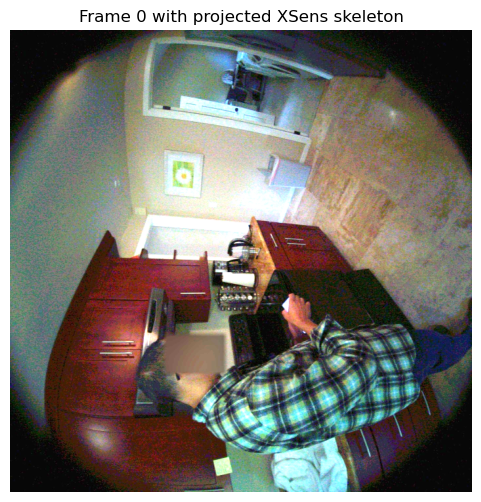

In [54]:
img_t, joints_3d, joints_2d = ds[0]
img_t_vis = F.normalize(img_t, mean=[-1, -1, -1], std =[ 0.5,  0.5, 0.5])
img_np = img_t_vis.permute(1,2,0).numpy()
parents = [-1,0,1,2,3,4,5,4,7,8,9,4,11,12,13,0,15,16,17,0,19,20,21]
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(img_np)
ax.axis('off')
u,v = joints_2d[:,0].numpy(), joints_2d[:,1].numpy()
for i,p in enumerate(parents):
    if p < 0:
        continue
    if u[i] < 0 or u[p] < 0:
        continue
    ax.plot([u[i],u[p]], [v[i],v[p]], c='lime', lw=2)
ax.scatter(u[v>=0], v[v>=0], c='red', s=15)
plt.title("Frame 0 with projected XSens skeleton")
plt.show()